# Test graph-tool visual tool 
---

In [22]:
"""Import the right packages."""
import itertools
import os
import sys

import graph_tool.all as gt
import networkit as nk
import numpy as np

# Get directory first
path = os.getcwd()
par_dir = os.path.abspath(os.path.join(path, ".."))
# Import own module
sys.path.append(par_dir)

if True:
    from network_utils.network_converter import NetworkConverter
    from network_utils.network_extractor import NetworkExtractor
    from network_utils.node_stats import NodeStats
    from simulators.meta_simulator import MetaSimulator
    from simulators.sim_mart_vaq import SimMartVaq
    from utils.plotter import Plotter

%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


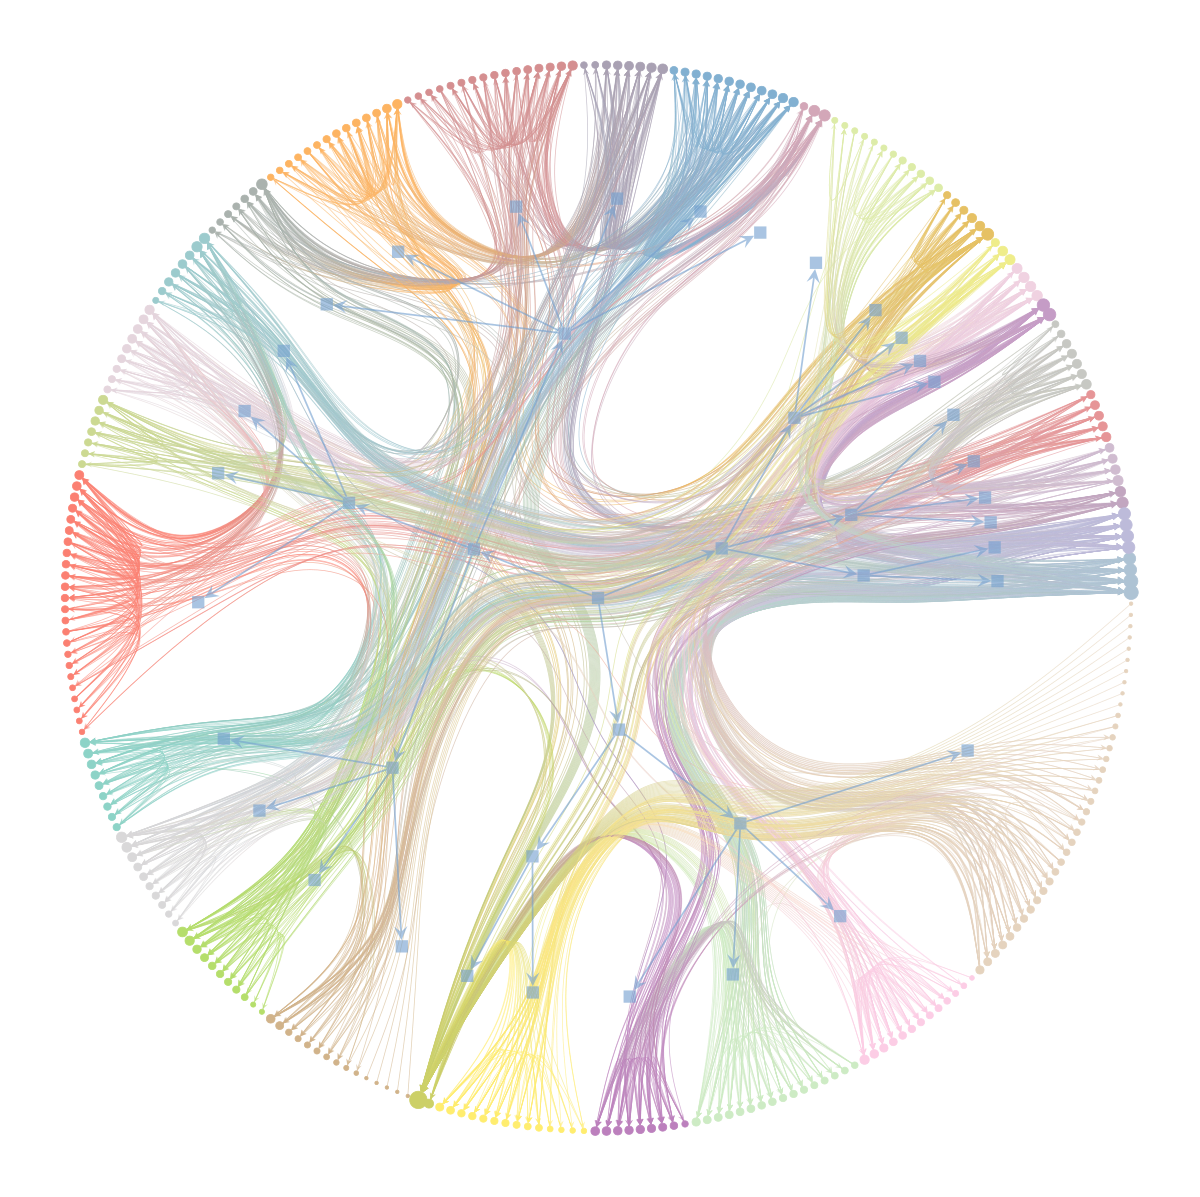

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa9556735b0, at 0x7fa8fb3164f0>,
 <Graph object, directed, with 340 vertices and 339 edges, at 0x7fa8fb33ad60>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa8fb33ad60, at 0x7fa8fb304280>)

In [5]:
"""Test if resulting graph is shown to prove graph-tool is installed."""

g = gt.collection.data["celegansneural"]
state = gt.minimize_nested_blockmodel_dl(g)
state.draw()

---

Test if random paritions is working.

Thereby it is important to check that the nodes of the same partition do have a connection.

Using OverlapBlockState

group_numbers=frozenset({0, 1, 2, 3})
list(mbr_list)=[0, 3, 0, 1, 0, 3, 3, 0, 3, 2, 3, 2, 0, 3, 3, 2, 1, 0, 0, 3, 2, 0, 0, 0, 2, 3, 0, 1, 1, 2, 3, 3, 0, 3, 2, 2, 0, 0, 1, 1, 3, 1, 3, 1, 1, 2, 3, 2, 0, 0, 1, 1]
list(mbr_list_2[0][0])=[0, 2, 3]


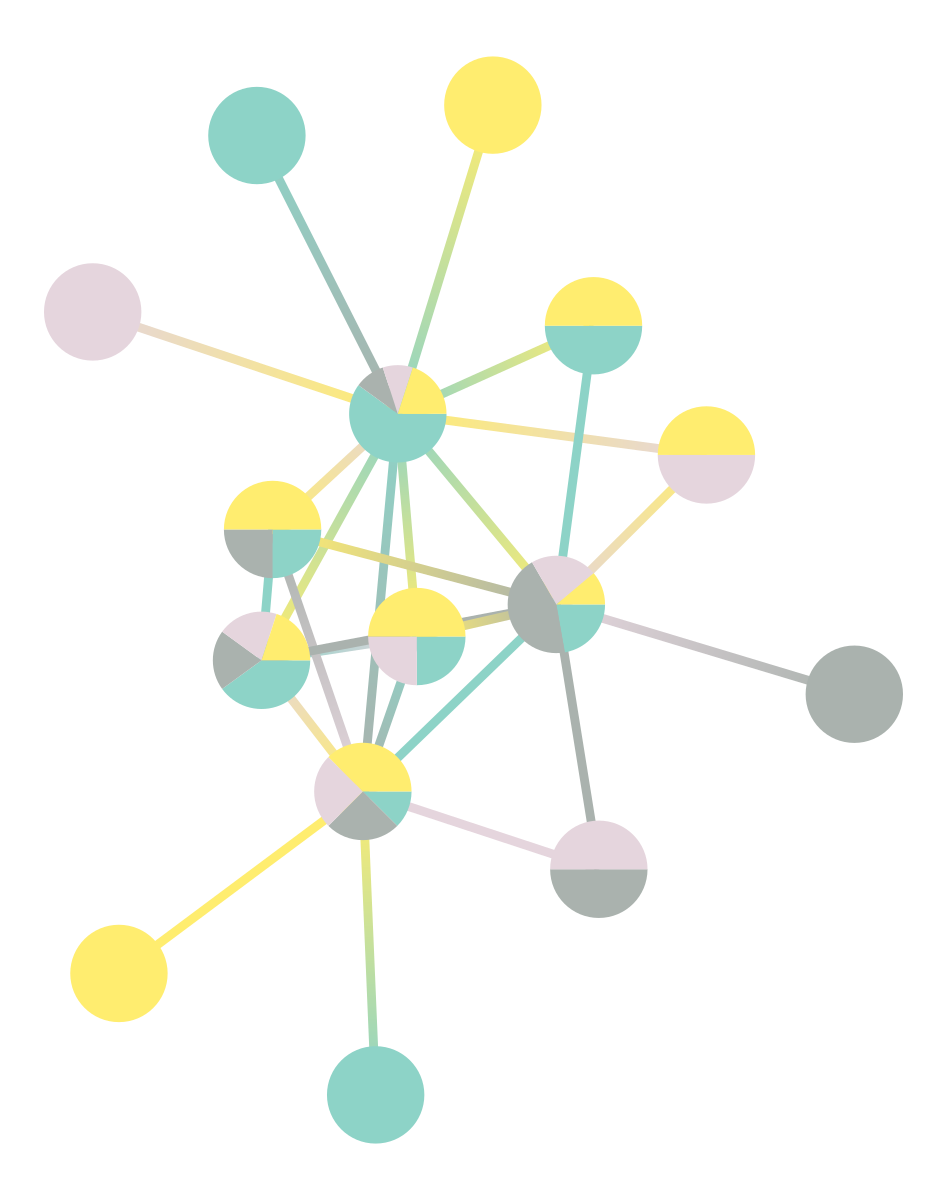

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa8fb307820, at 0x7fa8fb31df70>

In [6]:
def sample_k(max):
    """Sample number of connections."""
    accept = False
    while not accept:
        k = np.random.randint(1, max + 1)
        accept = np.random.random() < 1.0 / k
    return k


g = gt.random_graph(15, lambda: sample_k(40), directed=False)

partitions = gt.OverlapBlockState(g, B=4)
mbr_list = partitions.get_blocks()
mbr_list_2 = partitions.get_overlap_blocks()
group_numbers = frozenset(mbr_list)
print(f"{group_numbers=}")
print(f"{list(mbr_list)=}")
print(f"{list(mbr_list_2[0][0])=}")
partitions.draw()

group_numbers=frozenset({0})


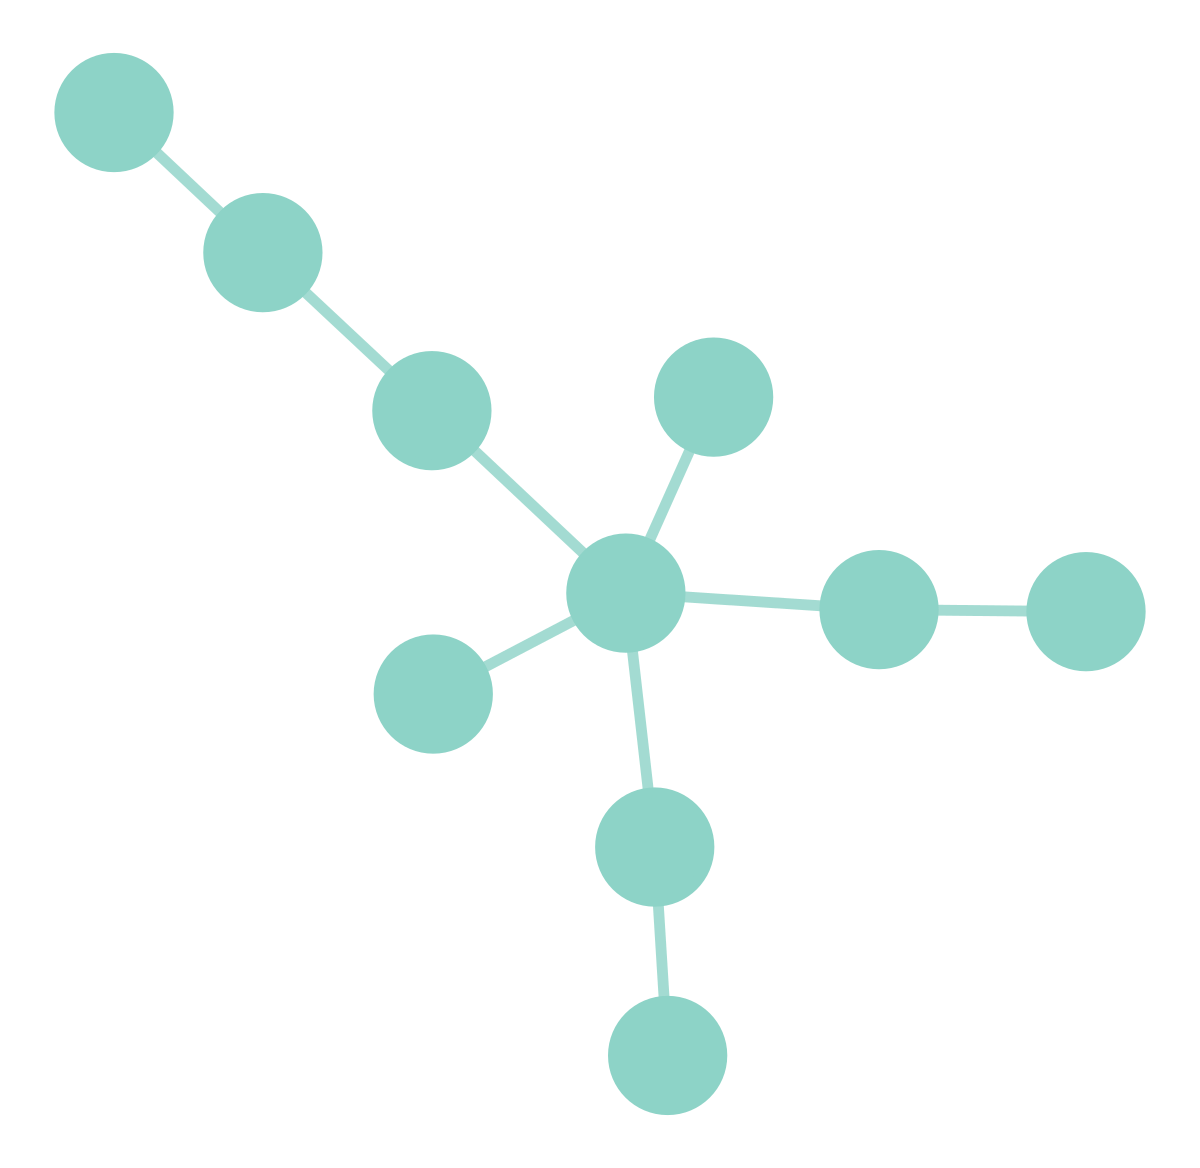

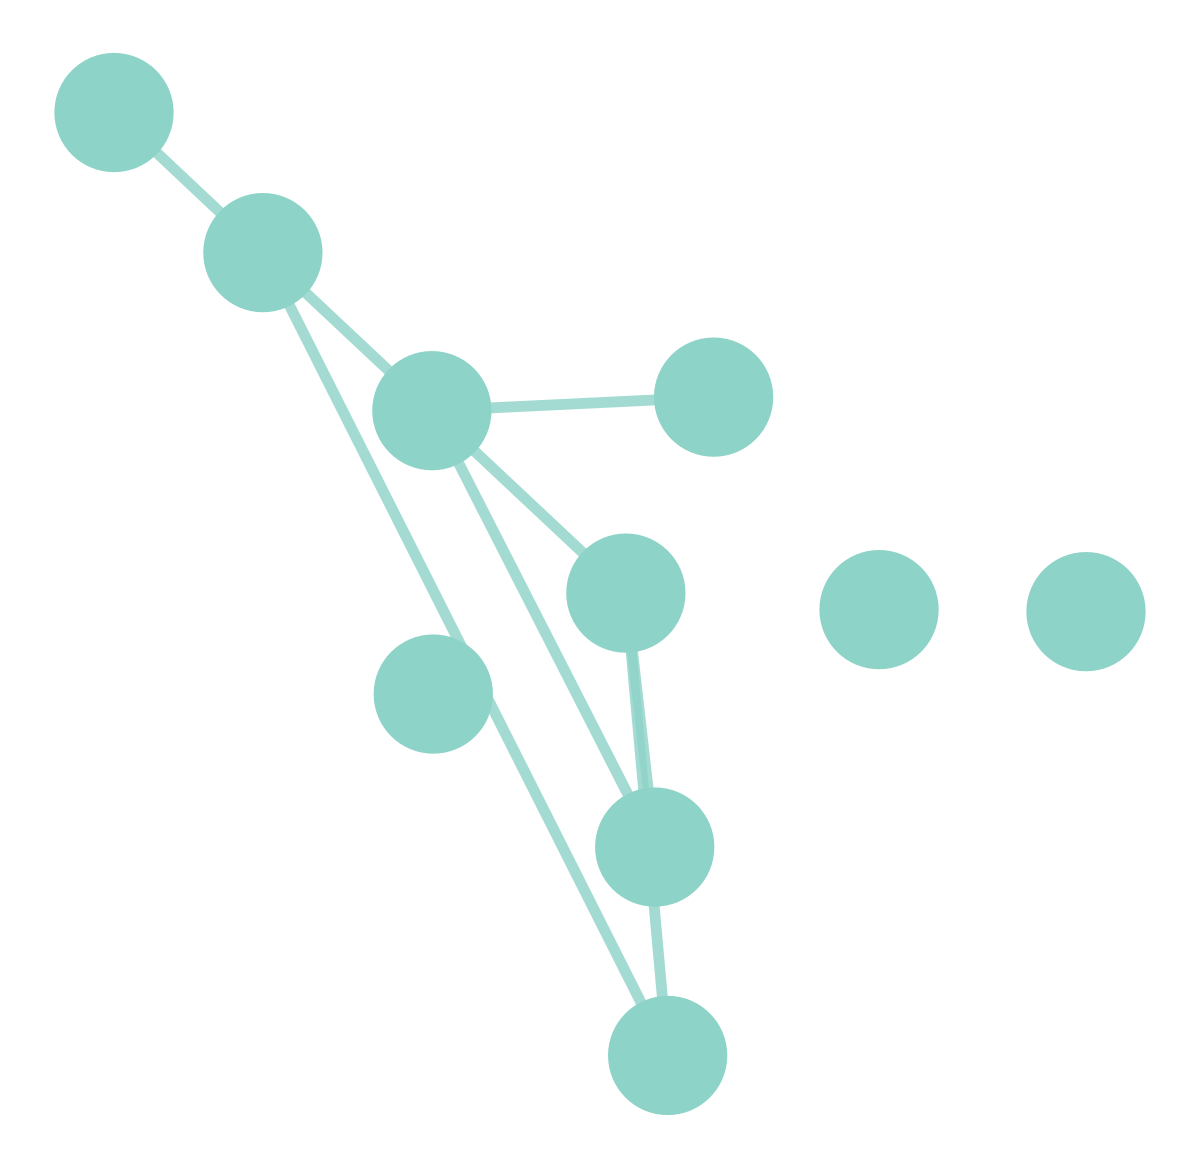

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa8fb33ec70, at 0x7fa8fb307760>

In [7]:
g = gt.price_network(10, m=1, directed=False)
pos = gt.sfdp_layout(g)

partitions = gt.minimize_blockmodel_dl(
    g, multilevel_mcmc_args={"B_min": 0.1 * g.num_vertices()}
)
mbr_list = partitions.get_blocks()
group_numbers = frozenset(mbr_list)
print(f"{group_numbers=}")
partitions.draw(pos=pos)

u = partitions.sample_graph(canonical=True, self_loops=False, multigraph=False)
ustate = gt.BlockState(u, b=partitions.b)
ustate.draw(pos=u.own_property(pos))

--- 
Verify the divide_network function visually

In [8]:
# Speed test
meta_sim = MetaSimulator(
    network_name="montagna_calls",
    ratio_honest=0.6,
    ratio_wolf=0.2,
    attachment_method="random",
)
simulators = SimMartVaq(meta_sim.network)

%timeit simulators.act_divide_in_groups_faster(simulators.network,min_grp=5,max_grp=10)
%timeit simulators.act_divide_in_groups(simulators.network,min_grp=5,max_grp=10)

6.98 ms ± 61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


  1%|          | 4/476 [00:00<00:01, 320.49it/s]

20.2 ms ± 334 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


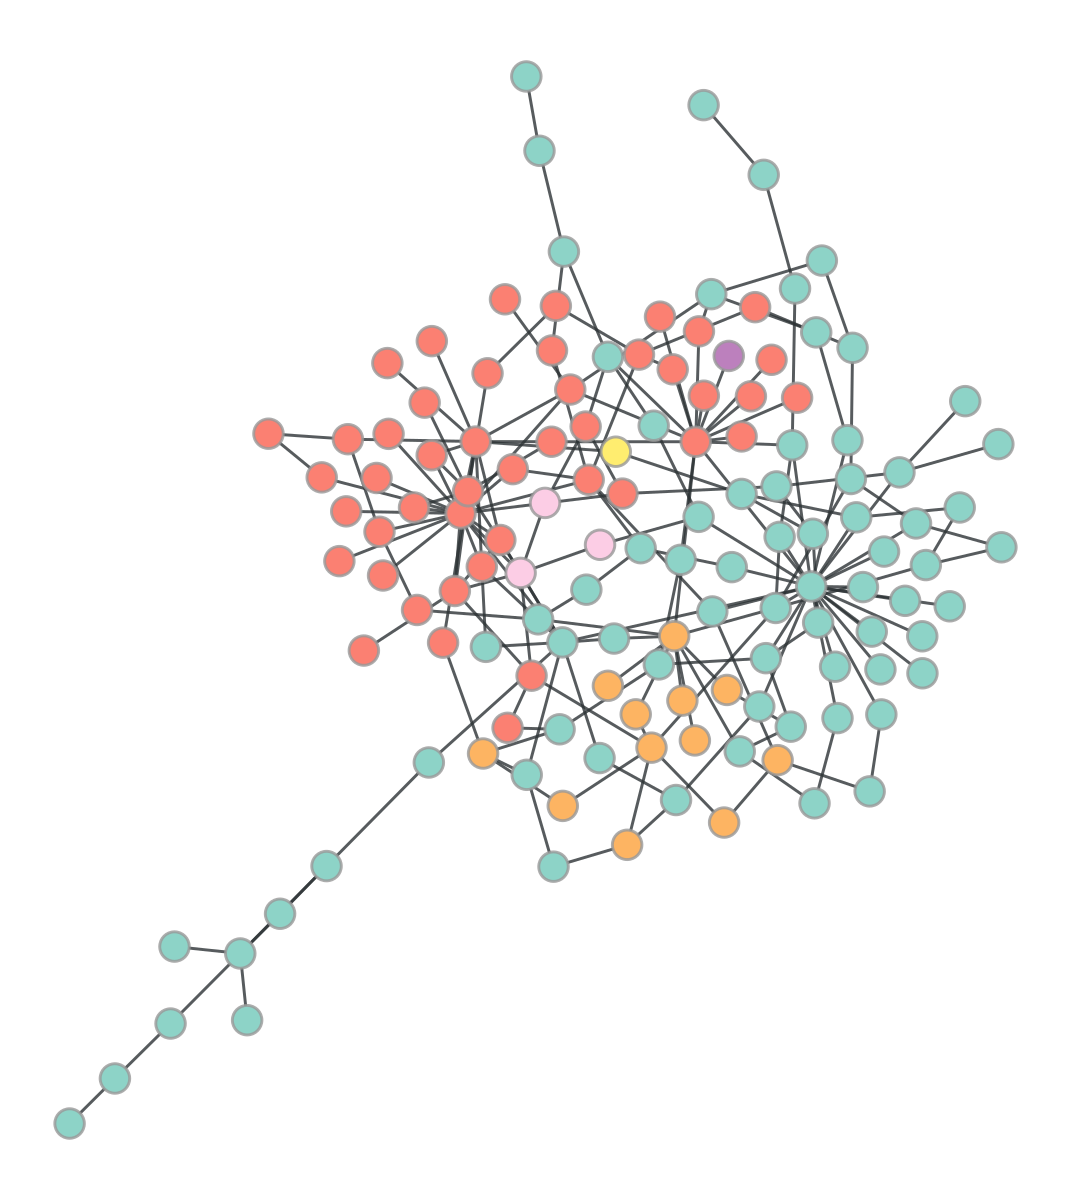

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa980248070, at 0x7fa970f3a4c0>

In [9]:
meta_sim = MetaSimulator(
    network_name="montagna_calls",
    ratio_honest=0.2,
    ratio_wolf=0.1,
    k=2,
    attachment_method="random",
)
simulators = SimMartVaq(meta_sim.network)
divided_network, _ = simulators.act_divide_in_groups_faster(
    simulators.network, min_grp=5, max_grp=10
)
pos = gt.sfdp_layout(divided_network)
gt.graph_draw(divided_network, pos=pos, vertex_fill_color=divided_network.vp.grp_nbr)

---
Test if the filtering is working correctly

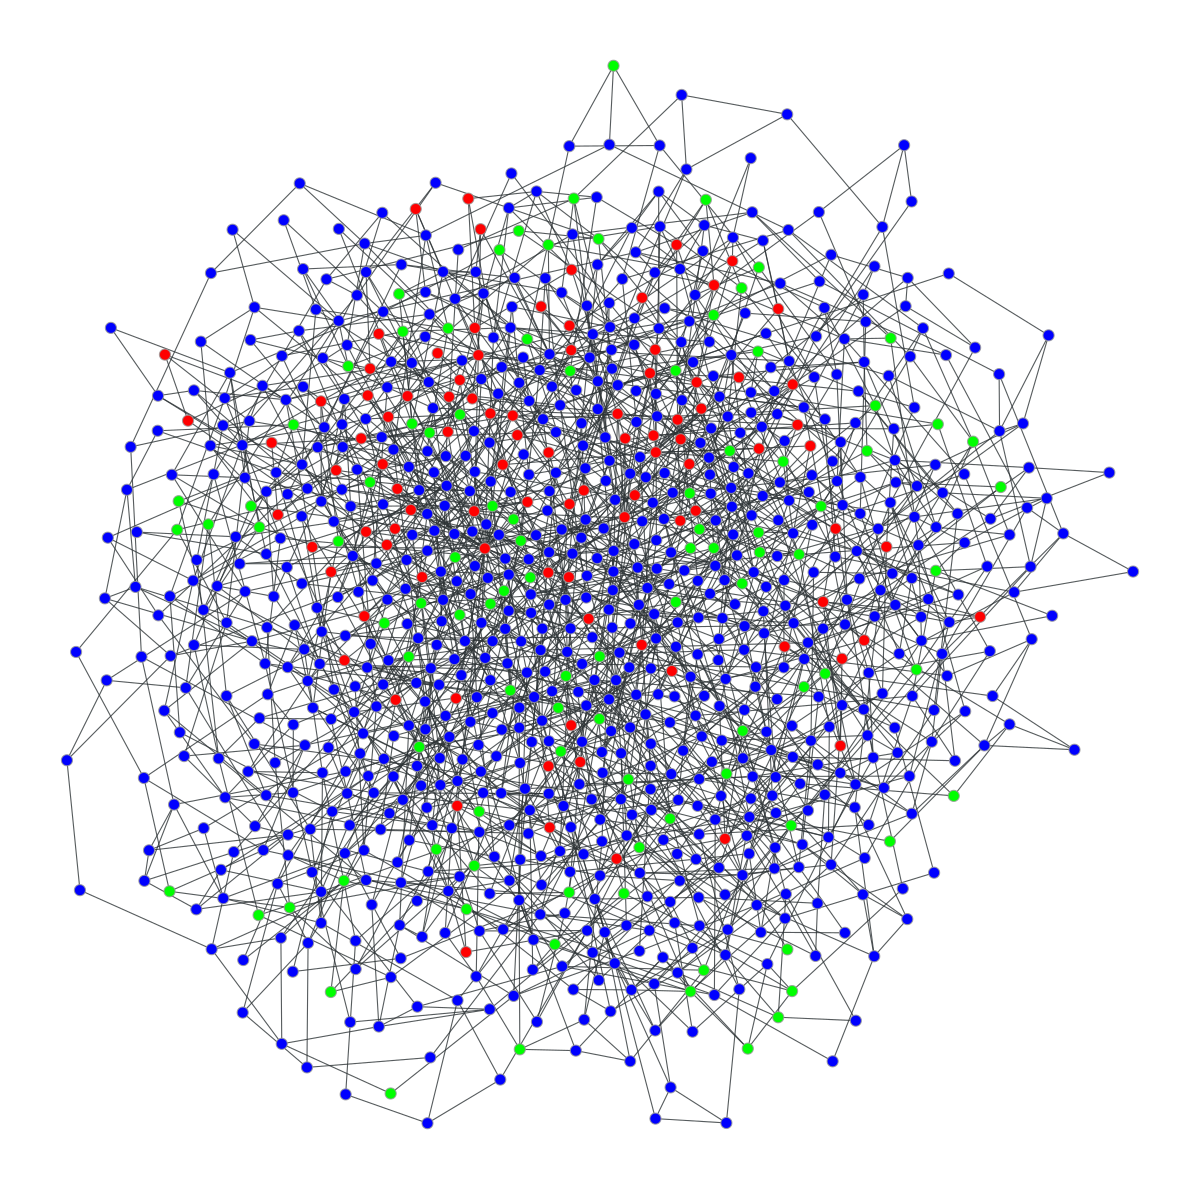

simulators.network.num_vertices()=95


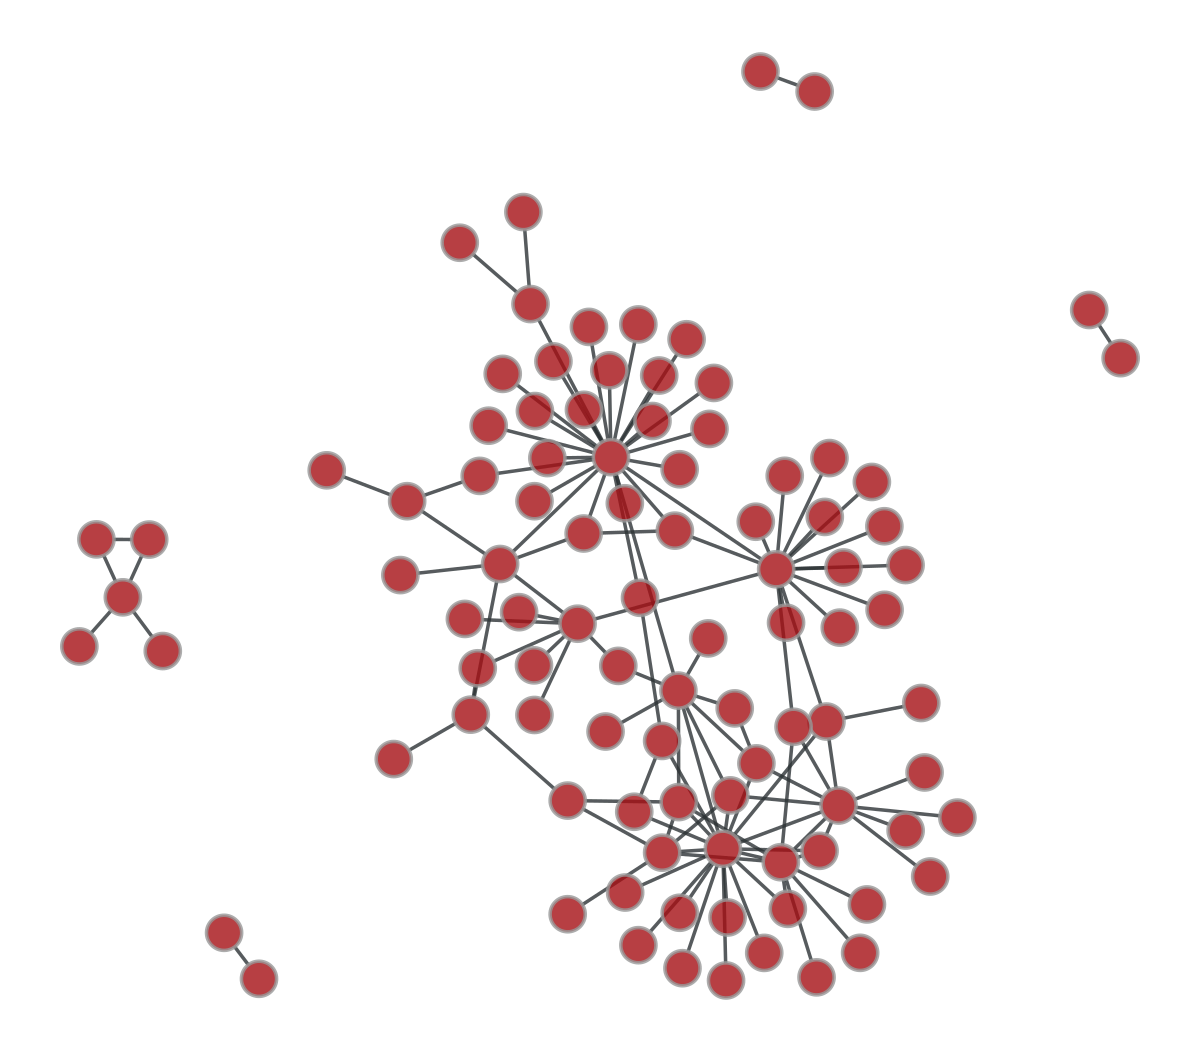

In [10]:
# Adding nodes based on preferential attachment
meta_sim = MetaSimulator(
    network_name="montagna_calls",
    ratio_honest=0.8,
    ratio_wolf=0.1,
    k=6,
    prob=0.4,
    attachment_method="small-world",
)
simulators = SimMartVaq(meta_sim.network)


plotter = Plotter()
plotter.args.draw_network = "n"
plotter.draw_network(network=simulators.network, color_vertex_property="state_color")


filtering = simulators.network.new_vertex_property("bool")
simulators.network.vertex_properties["filtering"] = filtering
for i in range(0, simulators.network.num_vertices()):
    if simulators.network.vp.state[simulators.network.vertex(i)] == "c":
        simulators.network.vp.filtering[simulators.network.vertex(i)] = 1
    else:
        simulators.network.vp.filtering[simulators.network.vertex(i)] = 0


simulators.network.set_vertex_filter(simulators.network.vp.filtering)
print(f"{simulators.network.num_vertices()=}")
plotter.draw_network(simulators.network)

In [11]:
# Get the different metrics
%timeit NodeStats.get_flow_of_information(simulators.network)
%timeit NodeStats.get_size_of_largest_component(simulators.network)
%timeit NodeStats.get_density(simulators.network)

1.85 s ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
430 µs ± 6.66 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
7.26 µs ± 45.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
def get_flow_of_information(network: gt.Graph) -> float:
    """Return the flow of information.

    Metric has been defined in
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6214327/
    """
    n_nodes = network.num_vertices()
    shortest_dist_list = []
    source_target = list(itertools.combinations(network.get_vertices(), 2))
    for s, t in source_target:
        shortest_dist_list.append(
            gt.shortest_distance(network, source=s, target=t, directed=False)
        )
    sum_inv_shortest_dist = sum(1 / dist for dist in shortest_dist_list)
    return (1 / (n_nodes * (n_nodes - 1))) * sum_inv_shortest_dist


u = gt.extract_largest_component(meta_sim.network)
get_flow_of_information(u)

0.17320950468540958

In [13]:
def get_flow_of_information_nk(gt_network):
    """Return the flow of information.

    Metric has been defined in
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6214327/
    """
    network = NetworkConverter.gt_to_nk(gt_network)
    n_nodes = network.numberOfNodes()
    apsp = nk.distance.APSP(network)
    apsp.run()

    distances = apsp.getDistances(asarray=True)
    inv_distances = np.reciprocal(distances)
    sum_inv_distances = np.triu(inv_distances, k=1).sum()
    return (1 / (n_nodes * (n_nodes - 1))) * sum_inv_distances


u = gt.extract_largest_component(meta_sim.network)
get_flow_of_information_nk(u)

0.1732095046854083

In [14]:
u = gt.extract_largest_component(meta_sim.network)
%timeit get_flow_of_information(u)
%timeit get_flow_of_information_nk(u)

1.45 s ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
568 µs ± 111 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Update the age of a node

In [15]:
# Adding nodes based on preferential attachment
meta_sim = MetaSimulator(
    network_name="montagna_calls",
    ratio_honest=0.96,
    ratio_wolf=0.01,
    k=6,
    prob=0.4,
    attachment_method="small-world",
)
simulators = SimMartVaq(meta_sim.network)

%timeit simulators.update_age(meta_sim.network)

187 µs ± 493 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [84]:
def update_age(network):
    """Update the age of a criminal node.

    Basically, count how many rounds a node has a criminal status criminal
    """
    nodes = gt.find_vertex(network, network.vp.state, "c")
    for node in nodes:
        network.vertex_properties["age"][node] += 1
    return network

In [85]:
%timeit simulators.update_age(meta_sim.network)

186 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
